# Работу выполнили Жилин Андрей Игоревич и Зимин Андрей Валерьевич

# Подготовка окружения
## Импорт необходимых библиотек

In [5]:
import math

import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

import matplotlib.patches as mpatches

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
##from mpl_toolkits import mplot3d 
##import seaborn as sns
from sklearn.model_selection import train_test_split

## Чтение Датасета

In [6]:
df = pd.read_csv("data/iris.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# 1 и 2 Задания


## Текст заданий

Текст заданий

1 Следует привести задачу классификации к бинарной. Т.е. рассматриваем
ирисы 2-х классов: Setosa и non-Setosa.


2 Из признаков оставляем только 2: sepal length и sepal width.

## Небольшие пояснения

Оставляем признаки "sepal_length" и "sepal_width", а также выделяем variety в отдельный dataframe. Класс iris-setosa помечаем 1, остальные классы помечаем -1.


In [7]:
y = pd.DataFrame()
X = df[["sepal_length", "sepal_width"]].to_numpy() #отбираем нужные признаки
y['variety'] = df["variety"].apply(lambda x: int(x == "Iris-setosa") - int(x != "Iris-setosa")) #функция для 1 и -1
y = y[['variety']].to_numpy() #переводим в numpy так как наш градиентный спуск работает с нампаем

print("Матрица признаков объектов:")
print(X[:10])
print("\nМатрица-столбец меток классов:")
print(y[45:55])

Матрица признаков объектов:
[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]]

Матрица-столбец меток классов:
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]]


## Выводы по первому и второму заданию

Импортировали данные и убедились в их корректности. Данные нам известные и хорошо знакомые.

# Подготовка перед выполнением третьего задания

## Наш градиентный спуск 
Наша реализация градиентного спуска с комментариями, взято из предыдущей лабораторной работы.

In [8]:
class GradientDescent:
    def __init__(self, train_x, train_y, h = 0.00005, eps=0.1, start_weights=None, logging=False, min_iterations=0, strategy="package", batch_size=1, lambda_=0, seed=19): #Добавил параметр лямбда для регуляризации
        np.random.seed(seed)
        #часть за данные
        self.X = train_x #тренировочная выборка
        self.y = train_y #целевой признак
        self.strategy = strategy #название стратегии(package, mini-batch или stochastic)

        #метаданные
        self.width = len(train_x[0]) + 1 #ширина тренировочной выборки
        self.height = len(train_x) #высота тренировочной выборки
        
        #модель 
        self.batch_size = batch_size
        self.min_iterations = min_iterations
        self.h = h #шаг градиентного спуска h > 0
        self.lambda_ = lambda_ #коэффициент регуляризации
        self.eps = eps #точность градиентного спуска
        self.strategies = {'package': self.step_package, 'mini-batch': self.step_mini_batch, 'stochastic': self.step_mini_batch}
        if strategy == 'stochastic':
            self.batch_size = 1
        if start_weights is None: #задание стартовых весов
            self.w = np.full(self.width, 1)
        else:
            self.w = start_weights 

        self.X = np.concatenate((np.ones(self.height).reshape(-1, 1), self.X), axis=1) #фиктивная единица
        self.q = self.calc_q() # инициализируем ошибку

        #логи
        self.logging = logging #вывод логов в консоль
        self.qs = np.array([]) #величина ошибки
        self.curr_timer = None #текущий таймер
        self.timer = np.array([]) #массив для хранения время итераций
        self.iter_num = 0 #количество итераций
        

    def start_timer(self): #засечь время
        self.curr_timer = datetime.datetime.now()
    
    def stop_timer(self): #становить и записать время
        self.timer = np.append(self.timer, np.array(datetime.datetime.now() - self.curr_timer))

    def get_time(self): #общее время выполнения программы
        return self.timer.sum()

    def get_times(self): #получить время по шагам
        return self.timer
    
    def step_package(self): #шаг пакетного градиентного спуска
        
        self.w = self.w - self.h * self.grad()  #вычисляем градиент по пакету и меняем веса

    
    def step_mini_batch(self): #шаг стохастического градиентного спуска или mini-batch зависит от размера пакета
        
        idx = np.random.randint(self.height, size=self.batch_size) # формируем индексы пакета
        self.w = self.w - self.h * self.grad(self.X[idx, :], self.y[idx, :]) #вычисляем градиент по пакету и меняем веса
        
    
    def grad(self, X = None, y = None): #вычисление градиента по пакету(подходит для mini-batch, package и stochastic)
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y

        return (X.T.dot(X.dot(self.w) - y[:, 0]))*(2/self.height)

    def fit(self): #запуск градиентного спуска
        
        q = 2*self.q

        if self.logging:
            print("Величина ошибки на каждом шаге")

        while abs(self.q - q) > self.eps or self.iter_num < self.min_iterations:
            self.start_timer()
            q = self.q #переприсваеваем значение ошибки 
            self.strategies[self.strategy]()
            self.qs = np.append(self.qs, q) #запоминаем значение ошибки
            self.q = self.calc_q() #вычисление значение ошибки после новых весов
            self.iter_num += 1
            self.stop_timer()
            if self.logging:
                print(f"Шаг {self.iter_num}: ошибка {round(self.q, int(np.log(1/self.eps)/np.log(10)))};") #логи        
        if self.logging:
            print(f"Время работы: {self.get_time().microseconds/1000:.02f} мс")
        return self.w


    def calc_q(self):
        
        return np.mean((np.dot(self.X, self.w) - self.y[:, 0]) ** 2) #вычисление ошибки

    def predict(self, X):
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.dot(X, self.w).reshape(-1, 1) #предсказание

## Наш метод опорных векторов
Реализация нашего метода опорных векторов 

Класс метода опорных векторов наследуется от градиентного спуска, так как для оптимизации будет использоваться градиентный спуск.
Переопределим градиент, функцию вычисления ошибки и предсказания.

В SVM в качестве оптимальной разделяющей прямой мы принимаем такую разделяющую прямую, которая максимально удалена от отбоих классов (имеет максимальный отступ). Для поиска такой прямой будем использовать функцию потерь Hingle Loss
$$L(w, x, y) = \lambda ||w||_2^2 + \sum_{i}^{n}{max(0, 1-y_i\langle{} w, x_i \rangle{})}$$ 
Где $\lambda$ - коэффициент регуляризации (необязателен).
Тогда градиент функции потерь будет иметь вид:
$$ \nabla_wL(y, X, w) = 2\lambda w + \sum_{i}^{n}{\begin{cases}0, {при }\, 1-y_i \langle{} w, x_i \rangle{} \leq 0 \\ -y_i*x_i, {при }\, 1-y_i \langle{} w, x_i \rangle{} > 0 \end{cases}}$$

In [9]:

class SupportVectorMachine(GradientDescent):#наследуемся от градиентного спуска
    
    def grad(self, X = None, y = None): #переопределяем вычисление градиента для нового класса svm
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y
        
        # Создаем булеву маску для объектов
        margins = 1 - y[:, 0] * np.dot(X, self.w)
        mask = margins > 0
        # Вычисляем градиент, используя булеву маску
        grad = -np.sum(y[mask, :] * X[mask], axis=0)
        # Добавляем коэффициент регуляризации
        return 2 * self.lambda_ * self.w  + grad
    
    def calc_q(self): #переопределяем функцию ошибки
        loss_result = self.lambda_*((self.w**2).sum())
        for i in range(self.height):
            loss_result += max(np.array([0.0]), 1 - self.y[i]*np.dot(self.w, self.X[i, :])) #линейное ядро
        return loss_result
    
    def predict(self, X): #переопределяем функцию предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.sign(np.dot(X, self.w).reshape(-1, 1)) #предсказание

## Наш класс для вычисления метрик

Повторение одних и тех же действий не очень полезно, особенно в программировании, потому необходимые вычисления метрик были вынесены в отдельный класс и будут вызываться как понадобится

Отдельно можно обратить внимание на метод get_hyper_p_2_params, здесь мы получаем уравнение двумерной гиперплоскости выражая один вес через другой, можно его расширить для больших размерностей, но пока задача для двумерного аффинного пространства

Приведем простой вывод формулы гиперплоскости


$
\\ 
\text{Гиперплоскость в общем виде} \\
w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n = 0 \\
w_nx_n = - (w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}) \\
x_n = -\frac{ w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}}{w_n} \\
\text{Теперь } x_n \text{ можно переобозначить как } f(x_1, x_2, \dots, x_{n - 1})\\
f(x_1, x_2, \dots, x_{n - 1}) = -\frac{ w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}}{w_n} \\
$

Вот мы и получили уравнение гиперплоскости

In [10]:
class Counter:
    def __init__(self, X_train, X_test, y_train, y_test, model):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred_train = model.predict(self.X_train)
        self.y_pred_test = model.predict(self.X_test)
        self.model = model
    def plot_confusion_matrix(self, y, y_pred, label): #построение матрицы 
        cm = confusion_matrix(y, y_pred)
        print('Матрица ошибок, полученная методом confusion_matrix\n', cm)
        
        ConfusionMatrixDisplay.from_predictions(y, y_pred)
        
        plt.title(f'Матрица ошибок для {label}')
        plt.show()
    
    def calc_metrics(self, y, y_pred): #расчет всех метрик для классификации
        acc = accuracy_score(y, y_pred)
        pre = precision_score(y, y_pred)
        rec = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        print(f"accuracy: {acc:.03f}")
        print(f"precision: {pre:.03f}")
        print(f"recall: {rec:.03f}")
        print(f"f1: {f1:.03f}")
        

    def try_model(self): #построение confusion matrix и расчет метрик на тестовой и тренировочной выборках
        self.y_pred_train = self.model.predict(self.X_train)
        self.y_pred_test = self.model.predict(self.X_test)
        print("Метрики для тренировочной выборки")
        self.calc_metrics(self.y_train, self.y_pred_train)
        print()
        print('Метрики для тестовой выборки')
        self.calc_metrics(self.y_test, self.y_pred_test)
        self.plot_confusion_matrix(self.y_train, self.y_pred_train, 'тренировочной выборки')
        self.plot_confusion_matrix(self.y_test, self.y_pred_test, 'тестовой')
    

# Задание 3



## Текст задания
Выполните процедуру классификации 3 раза. В рамках данной процедуры:

 Разбейте выборку случайным образом на обучающую (100 объектов) и
тестовую.

 Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.

 Приведите формулу разделяющей гиперплоскости.

 Оцените точность классификации на тестовой и обучающей выборках.

## Первая модель(три в одном)

Разбиение выборки на обучающую (мы помним, что объектов 150, потому параметр тестовой части 0.33, чтобы в обучающей было 100)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19) #устанавливаем random_state 19, чтобы не забыть эти данные


Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.

Мы хотим обучить тремя методами градиентного спуска и их сравнить для проведения дальнейших двух запусков

На первом запуске будем сравнивать пакетный, mini-batch и стохастический, на остальных двух будем запускать только один из них

### Пакетный градиентный спуск

In [12]:
svm = SupportVectorMachine(X_train,y_train, h=0.005, min_iterations=1000) #вызывает пакетный градиентный спуск
w_ = svm.fit()  #веса
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
3.080 + -3.390 x1 + 4.837 x2 = 0


#### Посчитаем метрики

Метрики для тренировочной выборки
accuracy: 0.990
precision: 1.000
recall: 0.970
f1: 0.985

Метрики для тестовой выборки
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


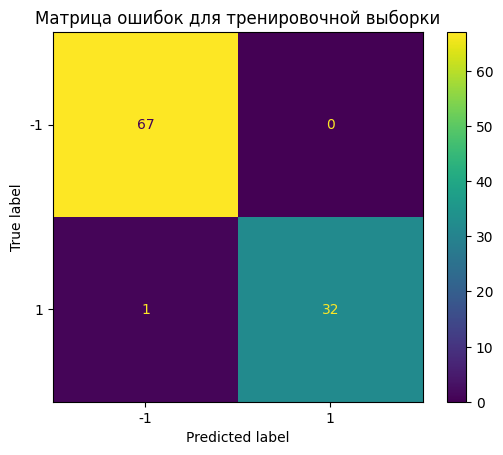

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


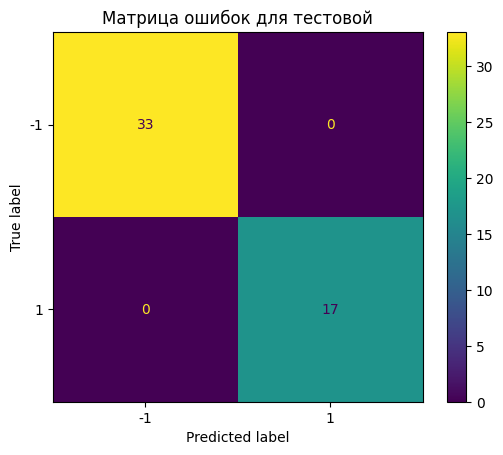

In [13]:
cntr_svm = Counter(X_train, X_test, y_train, y_test, svm)
cntr_svm.try_model()

### mini-batch

Всё то же самое для mini batch, но у него поменяем шаг, чтобы не разошелся

In [14]:
svm_mini_batch = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='mini-batch', batch_size=10) 
w_ = svm_mini_batch.fit()  #веса
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
1.350 + -2.069 x1 + 3.040 x2 = 0


#### Вновь считаем метрики

Метрики для тренировочной выборки
accuracy: 0.990
precision: 1.000
recall: 0.970
f1: 0.985

Метрики для тестовой выборки
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


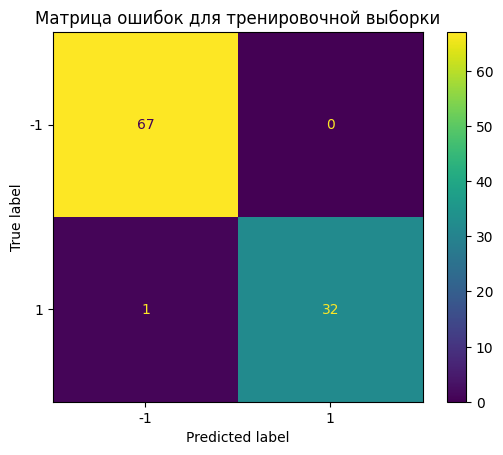

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


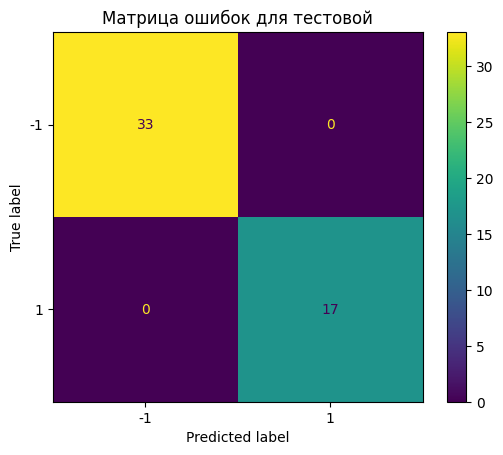

In [15]:
cntr_svm_mini_batch = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cntr_svm_mini_batch.try_model()

### Стохастический градиентный спуск

Остался последний способ, реализованный у нас, это стохастический градиент спуск задаем те же параметры, что и у mini-batch

In [16]:
svm_stochastic = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='stochastic') 
w_ = svm_stochastic.fit()
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
0.895 + -1.027 x1 + 1.448 x2 = 0


#### Метрики для стохастического

Метрики для тренировочной выборки
accuracy: 0.990
precision: 1.000
recall: 0.970
f1: 0.985

Метрики для тестовой выборки
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


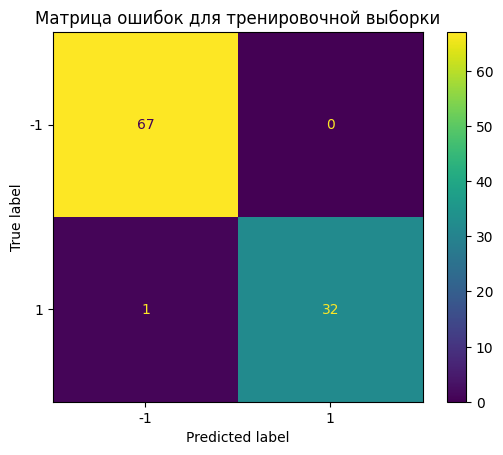

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


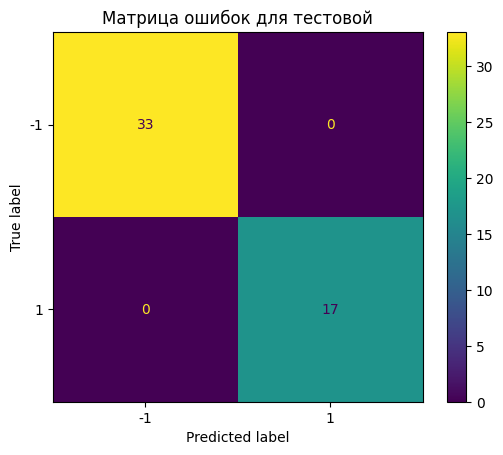

In [17]:
cntr_svm_stochastic = Counter(X_train, X_test, y_train, y_test, svm_stochastic)
cntr_svm_stochastic.try_model()

### Разделяющая гиперплоскость для всех трех

Строим гиперплоскость всех троих способов разделения

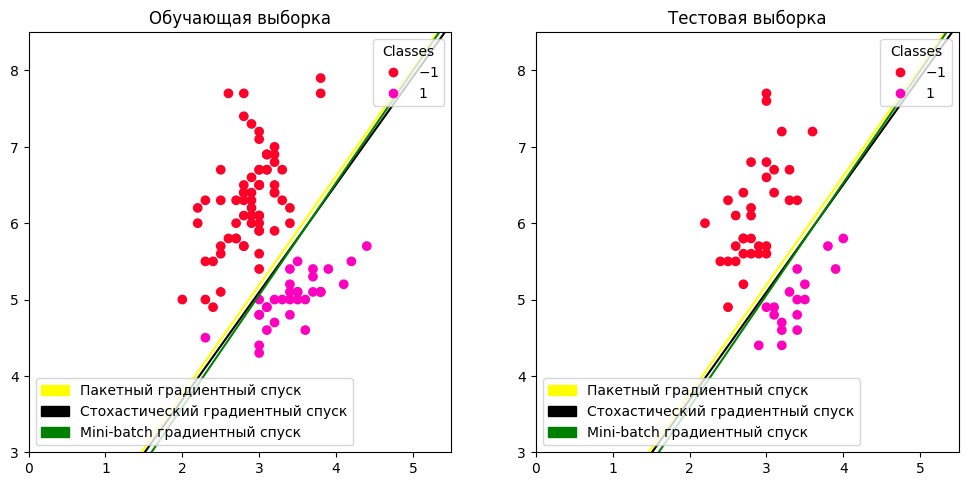

In [18]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

svm_w = svm.w 
svm_stochastic_w = svm_stochastic.w
svm_mini_batch_w = svm_mini_batch.w

svm_z = svm_w[0] + svm_w[2] * xgrid + svm_w[1]*ygrid
svm_stochastic_z = svm_stochastic_w[0] + svm_stochastic_w[2] * xgrid + svm_stochastic_w[1]*ygrid
svm_mini_batch_z = svm_mini_batch_w[0] + svm_mini_batch_w[2] * xgrid + svm_mini_batch_w[1]*ygrid

fig = plt.figure(figsize=(12, 12))

# Обучающая выборка

ax = fig.add_subplot(221)


scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")
plt.contour(x1, x2, svm_z, colors="yellow", levels=[0])
plt.contour(x1, x2, svm_stochastic_z, colors="black", levels=[0])
plt.contour(x1, x2, svm_mini_batch_z, colors="green", levels=[0])

svm_patch = mpatches.Patch(color="yellow", label='Пакетный градиентный спуск')
svm_s_patch = mpatches.Patch(color="black", label='Стохастический градиентный спуск')
svm_m_patch = mpatches.Patch(color="green", label='Mini-batch градиентный спуск')

plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

ax.set_title('Обучающая выборка')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.legend(handles=[svm_patch, svm_s_patch, svm_m_patch])


#тестовая выборка
ax = fig.add_subplot(222)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")

plt.contour(x1, x2, svm_z, colors="yellow", levels=[0])
plt.contour(x1, x2, svm_stochastic_z, colors="black", levels=[0])
plt.contour(x1, x2, svm_mini_batch_z, colors="green", levels=[0])

svm_patch = mpatches.Patch(color="yellow", label='Пакетный градиентный спуск')
svm_s_patch = mpatches.Patch(color="black", label='Стохастический градиентный спуск')
svm_m_patch = mpatches.Patch(color="green", label='Mini-batch градиентный спуск')

plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

ax.set_title('Тестовая выборка')
ax.add_artist(legend1)

ax.legend(handles=[svm_patch, svm_s_patch, svm_m_patch])




### Мини-выводы

По итогу метрики accuracy, precision и recall оказались одинаковыми, как следствие этого f0 тоже одинаковые

Визуально кажется, что все-таки пакетный градиентный спуск и mini-batch остается это узнать по функции ошибки 

In [19]:
print(f"SVM с пакетной оптимизацией: {svm.q[0]:.02f}")
print(f"SVM с мини-батч оптимизацией: {svm_mini_batch.q[0]:.02f}")
print(f"SVM с стохастической оптимизацией: {svm_stochastic.q[0]:.02f}")


SVM с пакетной оптимизацией: 2.88
SVM с мини-батч оптимизацией: 6.30
SVM с стохастической оптимизацией: 15.49


### Вывод по первой модели
У пакетного меньше всего ошибка, дальше будем продолжать работать с ним

## Вторая модель(только пакетный)

Новое разбиение для новой модели

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [21]:
svm_2 = SupportVectorMachine(X_train,y_train,  h=0.0005, min_iterations=10000) 
svm_2.fit()  #веса
w_ = svm_2.fit()
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
2.709 + -2.812 x1 + 4.017 x2 = 0


### Метрики

Метрики для тренировочной выборки
accuracy: 0.990
precision: 1.000
recall: 0.970
f1: 0.985

Метрики для тестовой выборки
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


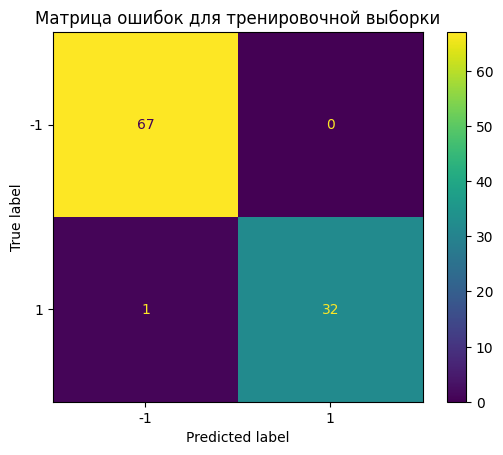

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


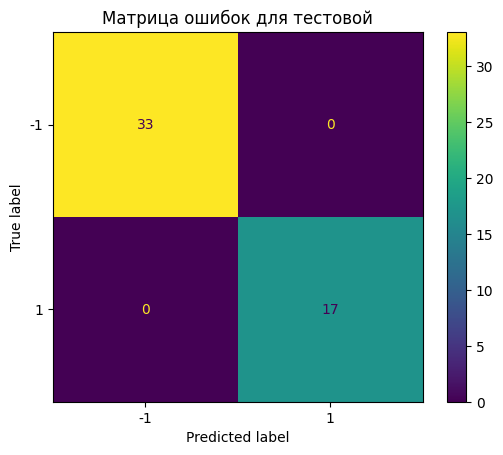

In [22]:
cntr_svm_2 = Counter(X_train, X_test, y_train, y_test, svm_2)
cntr_svm_2.try_model()

### График гиперплоскости 

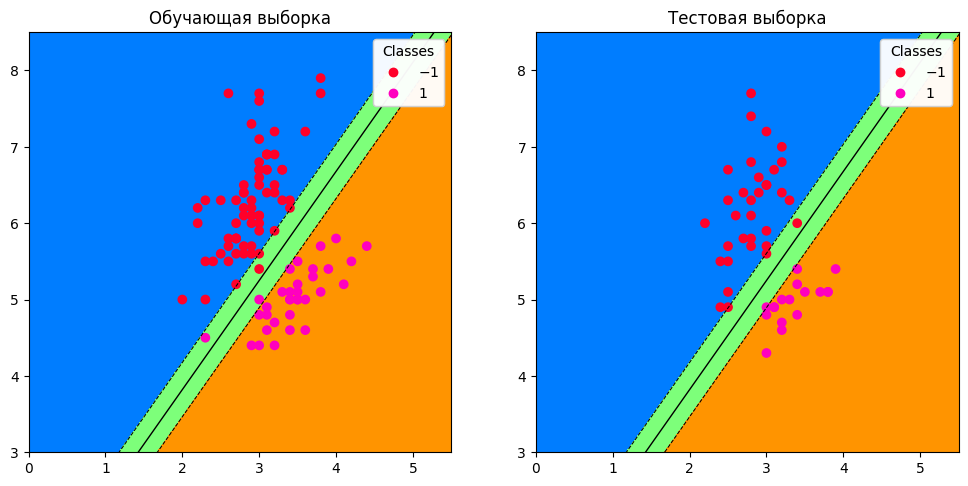

In [23]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = svm_2.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(221)
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")

ax.set_title('Обучающая выборка')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


#тестовая выборка
ax = fig.add_subplot(222)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")




legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)


plt.show()


Получилось достаточно неплохо, однако видно, что неидеально. Есть один объект класса 1, который попал к классу -1. Также есть несколько объектов в margin-зоне.

## Третья модель

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=122)

In [25]:
svm_3 = SupportVectorMachine(X_train, y_train, min_iterations=10000)
w_ = svm_3.fit()
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
1.295 + -1.992 x1 + 3.053 x2 = 0


Метрики для тренировочной выборки
accuracy: 0.990
precision: 1.000
recall: 0.971
f1: 0.986

Метрики для тестовой выборки
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
Матрица ошибок, полученная методом confusion_matrix
 [[65  0]
 [ 1 34]]


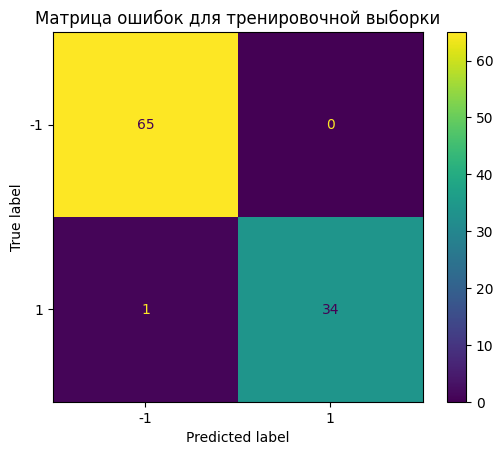

Матрица ошибок, полученная методом confusion_matrix
 [[35  0]
 [ 0 15]]


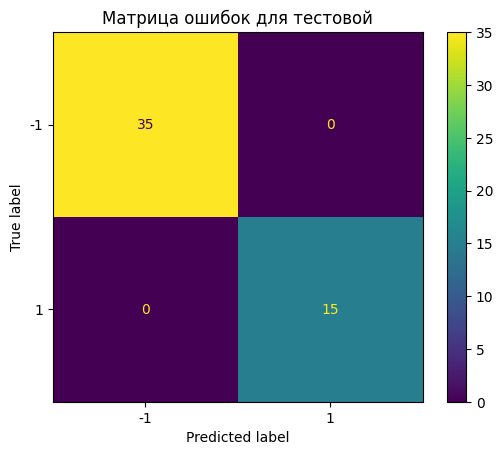

In [26]:
cntr_svm_3 = Counter(X_train, X_test, y_train, y_test, svm_3)
cntr_svm_3.try_model()

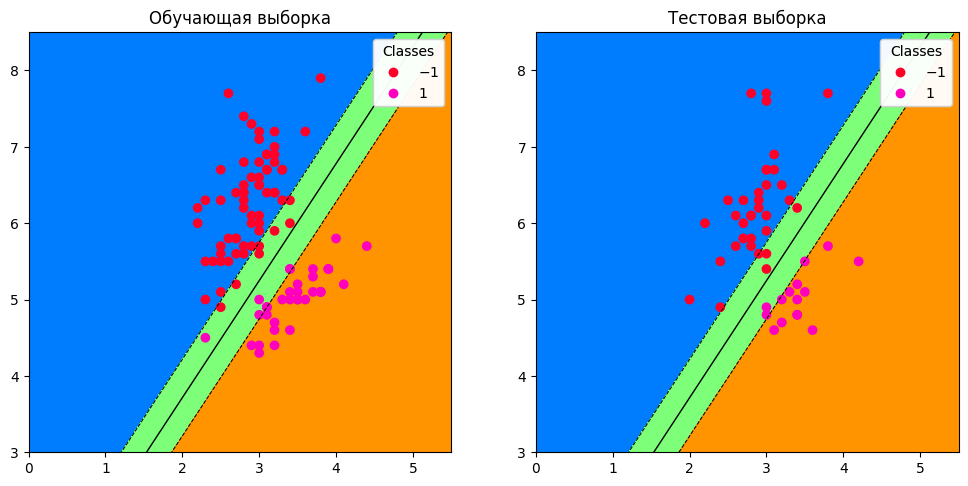

In [27]:

x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = svm_3.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(221)
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")

ax.set_title('Обучающая выборка')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


#тестовая выборка
ax = fig.add_subplot(222)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")




legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)


plt.show()

Похожая картина, но теперь из-за бОльшей ширины margin-зоны в неё попало больше объектов. На результатах классификации это не сказалось (такие у нас данные)

# Задание 4
## Текст задания
Сравните итоги выполненных ранее трёх попыток обучения. Сделайте
выводы.

## Пояснения
По итогу независимо от разбиения последний объект никак не получается отделить в обучающей выборке(так получилось, то он попал во всех трех разбиениях в обучающую выборку. Однако на всех тестовых выборках метрики 1. Значит модель не переобучилась и имеет хорошую обобщающую способность. 

По итогу можно сказать что выборка линейно неразделима, либо с точки зрения линейной модели слишком сильно пострадает обобщающая способность если подстраиваться под одну точку. 

Визуально кажется, что выборка линейна неразделима, но так может показаться из-за масштаба, так что для более корректного вывода следует исследовать сами данные

Если предположить, что тот один объект является выбросом (неверно указан класс при сборе датасета), то классы получатся линейно разделимы и всё хорошо.

# Задание 5




## Текст задания
Реализуйте задачу классификации с квадратичной функцией SVM на
последнем наборе обучающей и тестовой выборок (также диаграммой
рассеяния и линией раздела).

## Пояснения по поводу svm

Если мы не можем решить задачу линейного разделения в исходном пространстве признаков, то повышаем размерность, предполагая, что в новом пространстве признаков большей размерности задачу линейного разделения удастся решить.

Мы применили к объектам отображение $$f:R^2 \to R^5$$
а именно $$f(x) = (x_1, x_2, x_1^2, x_2^2, x_1x_2)$$

In [28]:
class QuadraSupportVectorMachine(SupportVectorMachine):#наследуемся от градиентного спуска
    def init_r(self):
        self.width = 6 #переопределим количество признаков
        self.to_new_r() #переведем их в пятимерное пространство
        self.w = np.array([1, 1, 1, 1, 1, 1]) #зададим новые стартовые веса для этого пространства
    def to_new_r(self, X = None): #добавляем переход в пятимерное пространство для данных
        
        flag_ = True
        if X is None:
            flag_ = False
            X = self.X
        
        X =  np.concatenate((np.ones((len(X), 3)), X), axis=1) #фиктивная единица
        for i in range(len(X)):
            
            X[i, :] = np.array([1, X[i, -1]**2, X[i, -2]**2, X[i, -1], X[i, -2], X[i, -1] * X[i, -2]])
        if flag_:
            return X
        self.X = X
    
    
    def predict(self, X): #переопределение функции предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        X = self.to_new_r(X) #перевод в новое пространство данных
        return np.sign(np.dot(X, self.w).reshape(-1, 1)) #предсказание
        
    

## Решение

Используем последнее разбиение для обучения новой модели

In [29]:
qsvm = QuadraSupportVectorMachine(X_train, y_train, h=0.0005, min_iterations=30000) #инициализация метода
qsvm.init_r() #для перехода в новое пространство
w_ = qsvm.fit()
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
1.963 + 0.828 x1 + -1.295 x2 + 2.122 x3 + 3.047 x4 + 0.222 x5 = 0


### Метрики

Метрики для тренировочной выборки
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000

Метрики для тестовой выборки
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
Матрица ошибок, полученная методом confusion_matrix
 [[65  0]
 [ 0 35]]


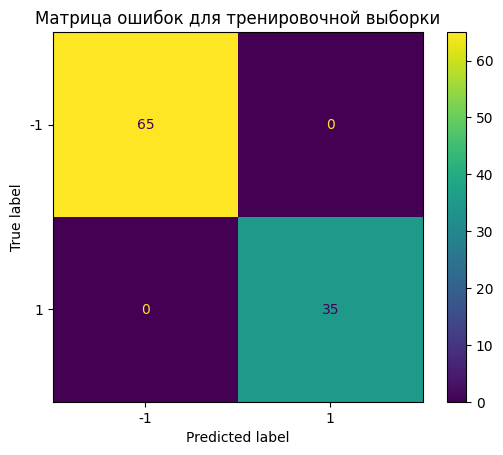

Матрица ошибок, полученная методом confusion_matrix
 [[35  0]
 [ 0 15]]


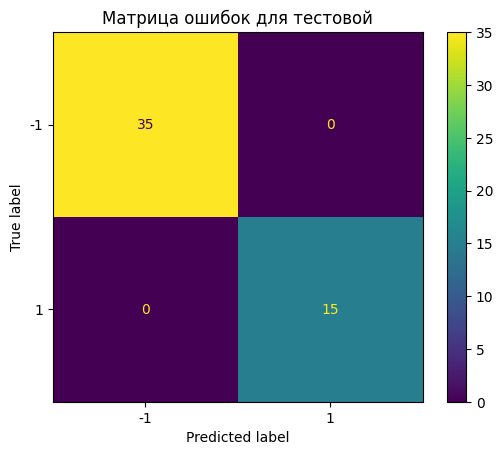

In [30]:
cntr_qsvm = Counter(X_train, X_test, y_train, y_test, qsvm)
cntr_qsvm.try_model()

### Линии уровня гиперплоскости

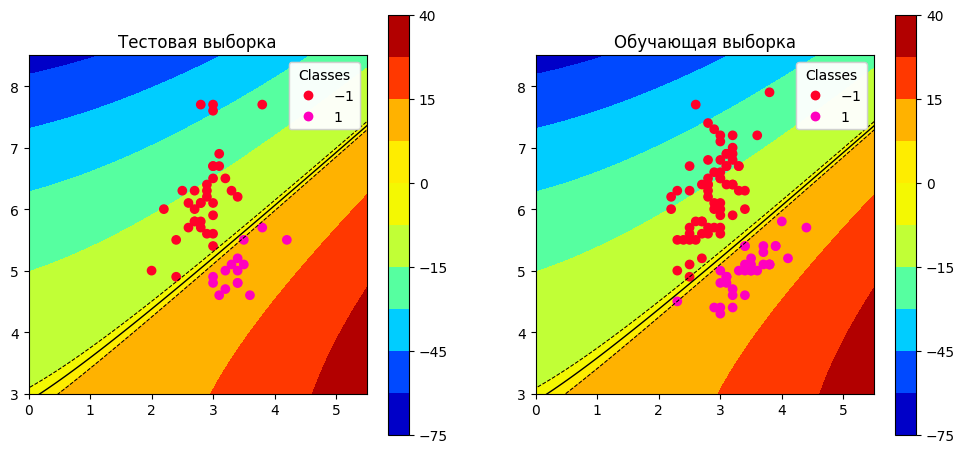

In [31]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

w = qsvm.w  
z = w[0] + w[1]*xgrid**2 + w[2]*ygrid**2 + w[3]*xgrid + w[4]*ygrid + w[5]*xgrid*ygrid 

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('Тестовая выборка')
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

ax = fig.add_subplot(222)


plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Обучающая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


plt.show()

## Выводы по svm с квадратичным ядром

Квадратичное ядро даже смогло описать ту точку с которой не справилась линейная svm. Сложно сказать переобучение это или такая природа предметной области. В самом начале мы удалили два признака, потому какие-то выводы сложно делать исходя из визуальных данных


# Задание 6

## Текст задания
Сравните точность классификации на тестовой выборке с линейной SVM.
Объясните результат.


## Решение
Точность классификации отличается, казалось бы, несильно, однако точность 1 и любая меньше 1 - абсолютно разные результаты. 

В обобщающей способности линейного классификатора нет сомнений поскольку это самая простая модель, за исключением константной, которая только может быть. 

Однако квадратичная могла и сильно подстроиться под ту одну точку, хотя в реальных данных там может оказаться много точек другого класса.

Может оказаться так, что все-таки там природно розовые точки, потому можно сделать вывод, что обе модели хорошо справились со своей задачей

# Задание 7
## Текст задания
Определите сорт 20 объектов из дополнительной выборки (файл «Dop.csv»).
Качество определения сорта проверит преподаватель.

## Пояснение перед решением

Для предсказания будем использовать две модели, чтобы визуально посмотреть насколько повлияли "выбросы" на предсказание модели в финальной тестовой выборки(мы не знаем ответы)

## Решение

In [32]:
df_dop = pd.read_csv("data/Dop.csv") ## чтение датасета
df_dop.head()

,Sepal.L,Sepal.W,Petal.L,Petal.W
0,6.0,2.9,4.9,1.6
1,5.2,3.0,2.4,0.5
2,5.7,2.8,4.5,1.4
3,5.4,3.4,2.3,0.9
4,6.7,3.3,5.4,2.0


In [33]:
y_dop = pd.DataFrame()
X_dop = df_dop[["Sepal.L", "Sepal.W"]].to_numpy() #отбираем нужные признаки


In [34]:
y_pred_qsvm_dop = qsvm.predict(X_dop)
y_pred_svm_dop = svm_3.predict(X_dop)

## Ответы

In [35]:
ans = pd.DataFrame()
ans["SVM Квадратичное ядро"] = y_pred_qsvm_dop[:, 0] #Ответы по модели с квадратичным ядром
ans["SVM линейное ядро"] = y_pred_svm_dop[:, 0] # Ответы по линейной модели
ans["Совпадение ответов"] = ans["SVM Квадратичное ядро"] == ans["SVM линейное ядро"]

ans

,SVM Квадратичное ядро,SVM линейное ядро,Совпадение ответов
0,-1.0,-1.0,True
1,1.0,1.0,True
2,-1.0,-1.0,True
3,1.0,1.0,True
4,-1.0,-1.0,True
5,-1.0,-1.0,True
6,-1.0,-1.0,True
7,-1.0,-1.0,True
8,-1.0,-1.0,True
9,-1.0,-1.0,True


### Пояснение к ответам
Скорее всего можно сказать, что мы гарантировали точность модели 0.95 на финальной тестовой выборке, поскольку у двух хороших моделей 95 процентов ответов совпали



##  Визуализация ответов

(500, 500)


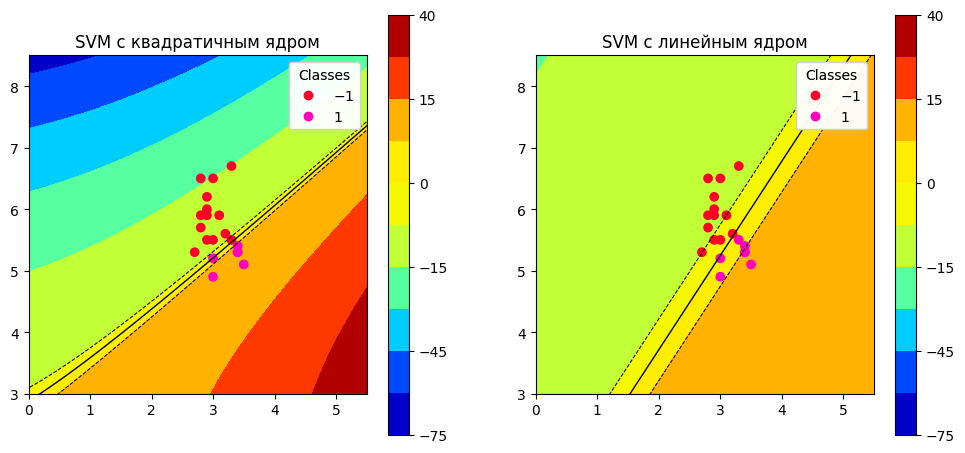

In [36]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

w = qsvm.w  
z = w[0] + w[1]*xgrid**2 + w[2]*ygrid**2 + w[3]*xgrid + w[4]*ygrid + w[5]*xgrid*ygrid 

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_dop[:, 1], X_dop[:, 0], c=y_pred_qsvm_dop, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('SVM с квадратичным ядром')
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

ax = fig.add_subplot(222)
w = svm_3.w 
z = w[0] + w[2] * xgrid + w[1]*ygrid

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_dop[:, 1], X_dop[:, 0], c=y_pred_svm_dop, cmap="gist_rainbow", marker="o")
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
ax.set_aspect('equal', adjustable='box')
ax.set_title('SVM с линейным ядром')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
print(z.shape)

plt.show()

### Пояснение к визуализации

Можно сказать, что на ответ повлияла та точка, поскольку сильно оттянулась кривая. Однако гипотетическая точность у обоих моделей все равно очень хорошая

# Дополнительно

# Задание 1
## Текст задания
Реализуйте нелинейную SVM с гауссовой или сигмоидальной
функцией ядра. Сравните результаты с предыдущими вариантами
классификации +3 балла.

Запишем задачу оптимизации для SMO [Эта постановка была взята отсюда 46 страница](https://logic.pdmi.ras.ru/~sergey/teaching/mlau12/08-svm.pdf)

$$  \frac12 \sum_{i=1}^{n}\sum_{j=1}^{m} y_iY_j\alpha_i\alpha_jK(x_i, X_j) - \sum_{i=1}^{m}\alpha_i \to min_{\alpha}$$
Где $ K(x_i, x_j)$ - функция ядра 

Гауссовское ядро (RBF ядро):
$$K(\mathbf{x_i}, \mathbf{x_j}) = e^{-\frac{\|\mathbf{x_i} - \mathbf{x_j}\|^2}{2\sigma^2}}, \quad \mathbf{x_i}, \mathbf{x_j} \in \mathbb{R}^d, \, \sigma > 0, \\ \text{или} \\ K(\mathbf{x_i}, \mathbf{x_j}) = e^{-\lambda \|\mathbf{x_i} - \mathbf{x_j}\|^2}, \quad \mathbf{x_i}, \mathbf{x_j} \in \mathbb{R}^d, \, \lambda > 0$$

Где σ и λ — это ширина ядра. В первом случае, чем меньше значение σ, тем меньше значение под экспонентой и тем более чувствительно ядро к изменениям. Во втором, наоборот, чем больше значение λ, тем более чувствительно. 
Источник: [Интуитивное понимание пространств и ядер в машинном обучении](https://habr.com/ru/articles/814343/)

## Решение 
Для решения этой задачи воспользуемся литературой [SMO 9 страница вывод, 12 страница итоговые формулы](https://courses.cs.tau.ac.il/0368-4341/shared/Papers/SMO/smo%20code%20and%20documentation.pdf)

Тут происходит очень сложная математика, которую тяжеловато объяснить, но мы вроде разобрались.

Есть проблема что Гауссово ядро не представимо в виде конечномерного спрямляющего пространства, если его расписать в ряд Тейлора, мы получим бесконечномерное пространство. Мы решили апроксимировать гауссово ядро, используя разложение в ряд Тейлора с остаточным членом (ограничились размерностью порядка n). 

Для квадратичного ядра, даже необязательно расписывать во формуле Тейлора, так как это полином легко свести 

Ещё был другой вариант развития событий - не использовать спремляющее пространство, а использовать только лишь функцию ядра, которая вычислит необходимое нам произведение в бесконечномерном пространстве для признаков из исходного пространства. Идея очень хорошая, однако, возникает проблема оптимизации, потому что градиентный спуск здесь уже ничем не поможет. 

Формально, задача, поставленная выше - задача квадратичного программирования. Мы нашли метод SMO - 
Sequential minimal optimization, который позволяет эффективно данную задачу решить, однако он достаточно сложный для понимания и реализации. Мы хотели его реализовать, но нам, к сожалению, не хватило на это времени.

Источник: [John C. Platt; Sequential Minimal Optimization A Fast Algorithm for Training Support Vector Machines](https://www.researchgate.net/publication/2624239_Sequential_Minimal_Optimization_A_Fast_Algorithm_for_Training_Support_Vector_Machines)
Статья 1998 года на английском языке

In [37]:
class GaussSVM(SupportVectorMachine):
    def init_r(self, n):
            self.width = n*n #переопределим количество признаков
            self.to_new_r() #переведем их в пятимерное пространство
            self.w = np.ones(n*n)#зададим новые стартовые веса для этого пространства
    def to_new_r(self, X = None): #добавляем переход в пятимерное пространство для данных
        
        flag_ = True
        if X is None:
            flag_ = False
            X = self.X
        print(X)
        x1 = X[:, 1]
        x2 = X[:, 2]
        C = np.zeros((X.shape[0],self.width))
        new_x1 = np.zeros((int(self.width**(1/2)), x1.shape[0]))
        new_x2 = np.zeros((int(self.width**(1/2)), x1.shape[0]))
        
        for x in range(int(self.width**(1/2))):
            new_x1[x] = -(1 - x1)**(2*x)/math.factorial(x)
            new_x2[x] = -(1 - x2)**(2*x)/math.factorial(x)
        for i in range(int(self.width**(1/2))):
            for j in range(int(self.width**(1/2))):
                C[:, i * int(self.width**(1/2)) + j] = new_x1.T[:, i] * new_x2.T[:, j]

        if flag_:
            return C
        self.X = C
    
    
    def predict(self, X): #переопределение функции предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        X = self.to_new_r(X) #перевод в новое пространство данных
        return np.sign(np.dot(X, self.w).reshape(-1, 1)) #предсказание

In [38]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

In [39]:
test_svm = GaussSVM(X_scaled_train, y_train, h=0.0005, min_iterations=500)
test_svm.init_r(5)


[[1.         0.44444444 0.41666667]
 [1.         0.41666667 0.25      ]
 [1.         0.69444444 0.41666667]
 [1.         0.11111111 0.5       ]
 [1.         0.72222222 0.45833333]
 [1.         0.19444444 0.625     ]
 [1.         0.30555556 0.70833333]
 [1.         0.19444444 0.        ]
 [1.         0.61111111 0.41666667]
 [1.         0.66666667 0.54166667]
 [1.         0.47222222 0.08333333]
 [1.         0.66666667 0.20833333]
 [1.         0.36111111 0.20833333]
 [1.         0.94444444 0.41666667]
 [1.         0.55555556 0.54166667]
 [1.         0.33333333 0.16666667]
 [1.         0.55555556 0.29166667]
 [1.         0.55555556 0.33333333]
 [1.         0.16666667 0.20833333]
 [1.         0.55555556 0.20833333]
 [1.         0.75       0.5       ]
 [1.         0.61111111 0.41666667]
 [1.         0.47222222 0.58333333]
 [1.         0.13888889 0.45833333]
 [1.         0.41666667 0.29166667]
 [1.         0.36111111 0.29166667]
 [1.         0.36111111 0.375     ]
 [1.         0.33333333 0.20

In [40]:
test_svm.fit()


array([-0.975     , -2.156125  , -0.0791477 ,  0.75839291,  0.95748102,
        2.42424113,  0.17927104,  0.5970671 ,  0.89719135,  0.98050506,
        1.82609038,  0.91833883,  0.91529159,  0.97509192,  0.99494552,
        1.22737557,  1.0063809 ,  0.98742866,  0.99563211,  0.99905624,
        1.04358082,  1.00391296,  0.9985805 ,  0.99939269,  0.99986095])

Видим, что размерность растёт с квадратичной скоростью

[[1.         0.44444444 0.41666667]
 [1.         0.41666667 0.25      ]
 [1.         0.69444444 0.41666667]
 [1.         0.11111111 0.5       ]
 [1.         0.72222222 0.45833333]
 [1.         0.19444444 0.625     ]
 [1.         0.30555556 0.70833333]
 [1.         0.19444444 0.        ]
 [1.         0.61111111 0.41666667]
 [1.         0.66666667 0.54166667]
 [1.         0.47222222 0.08333333]
 [1.         0.66666667 0.20833333]
 [1.         0.36111111 0.20833333]
 [1.         0.94444444 0.41666667]
 [1.         0.55555556 0.54166667]
 [1.         0.33333333 0.16666667]
 [1.         0.55555556 0.29166667]
 [1.         0.55555556 0.33333333]
 [1.         0.16666667 0.20833333]
 [1.         0.55555556 0.20833333]
 [1.         0.75       0.5       ]
 [1.         0.61111111 0.41666667]
 [1.         0.47222222 0.58333333]
 [1.         0.13888889 0.45833333]
 [1.         0.41666667 0.29166667]
 [1.         0.36111111 0.29166667]
 [1.         0.36111111 0.375     ]
 [1.         0.33333333 0.20

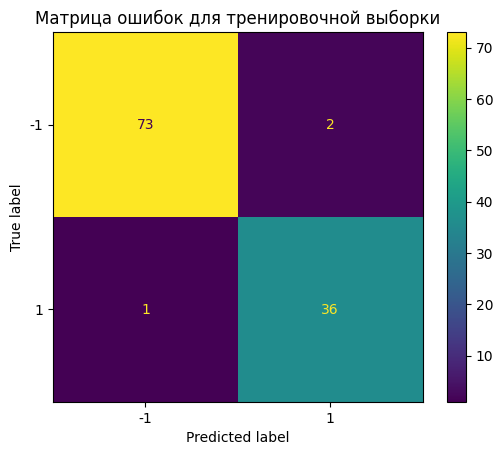

Матрица ошибок, полученная методом confusion_matrix
 [[25  0]
 [ 1 12]]


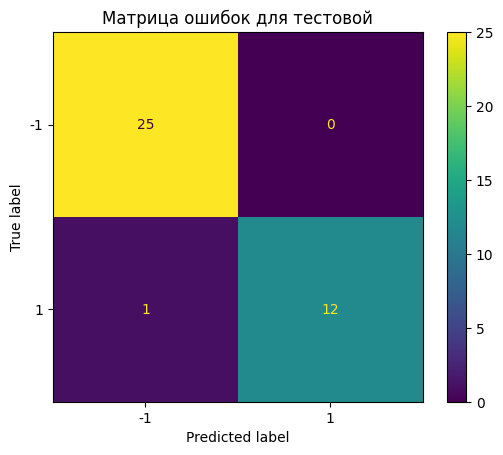

In [41]:
test_svm_cntr = Counter(X_scaled_train, X_scaled_test, y_train, y_test, test_svm)
test_svm_cntr.try_model()

Получилось не хуже, чем в прошлых разах

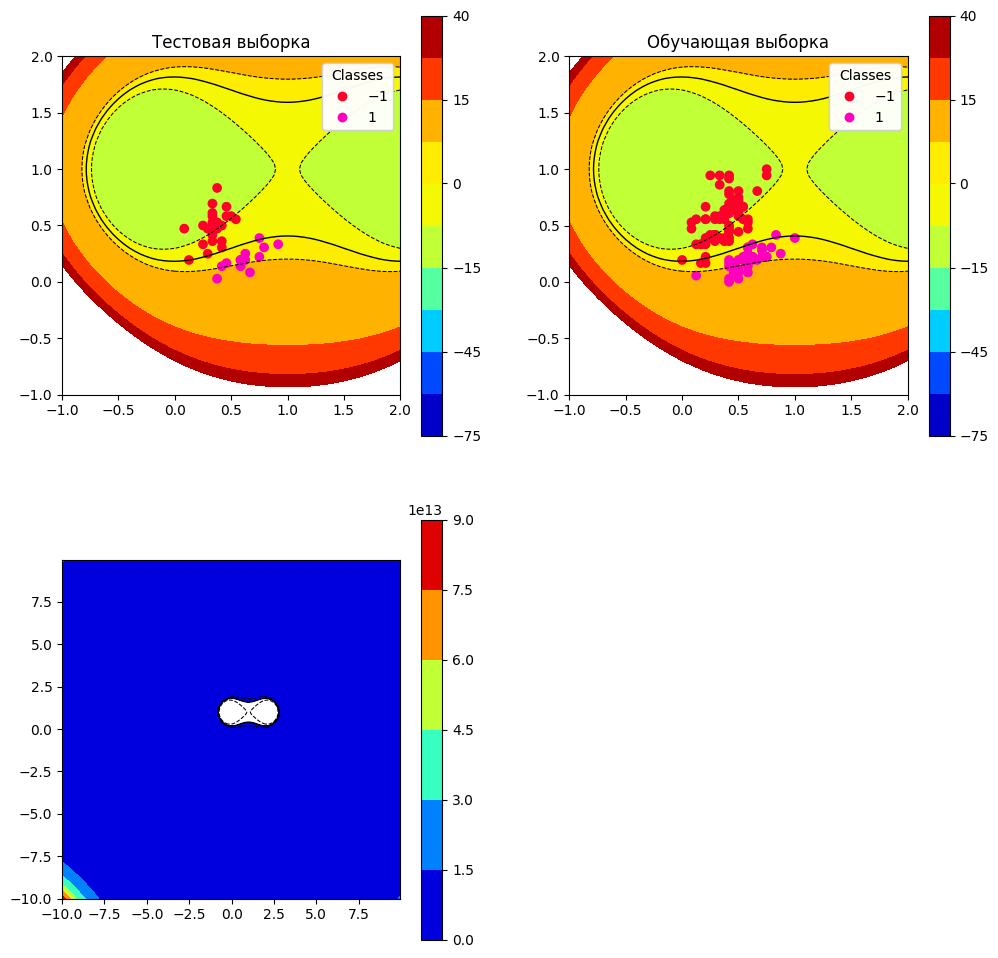

In [42]:
x1 = np.arange(-10, 10, 0.05)
x2 = np.arange(-10, 10, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)


wid = test_svm.width
w = test_svm.w

C = np.zeros(( x1.shape[0], x1.shape[0], test_svm.width))
new_x1 = np.zeros(( int(wid**(1/2)), x1.shape[0], x1.shape[0]))
new_x2 = np.zeros(( int(wid**(1/2)), x1.shape[0], x1.shape[0]))

for x in range(int(wid**(1/2))):
    new_x1[x] = -(1 - xgrid)**(2*x)/math.factorial(x)
    new_x2[x] = -(1 - ygrid)**(2*x)/math.factorial(x)

for i in range(int(wid**(1/2))):
    for j in range(int(wid**(1/2))):

        C[: , :, i * int(wid**(1/2)) + j] = new_x1.T[:, :,  i] * new_x2.T[:, :, j]
        

z = np.ones((C.shape[0], C.shape[1]))
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        z[i, j] = (C[i, j, :]*w).sum()
        


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_scaled_test[:, 1], X_scaled_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('Тестовая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

ax = fig.add_subplot(222)


plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_scaled_train[:, 1], X_scaled_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")
plt.xlim(-1, 2)
plt.ylim(-1, 2)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Обучающая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax = fig.add_subplot(223)

ax.set_aspect('equal', adjustable='box')

plt.contourf(x1, x2, z, cmap="jet")
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])

plt.show()      

Получилось достаточно интересное ядро. На самом деле вряд ли можно его назвать гауссовым, скорее это апроксимация гауссова ядра с помошью полиномиального ядра. Выглядит красиво. На этих данных модель скорее переобучилась - слишком хорошо подстроилась под исходные точки, однако, для более сложных и запутанных распределений данных такое едро будет работать заметно лучше чем линейное или квадратичное.

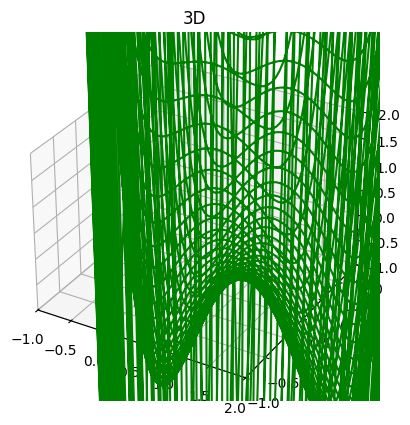

In [43]:
ax = plt.axes(projection ='3d')
ax.plot3D(xgrid, ygrid, z, 'green')
ax.set_title('3D')
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
ax.set_zlim(-1, 2)
plt.show()

Тут хотели вывести трёхмерный график. Вероятно мы просчитались - но где?

# Задание 2
## Текст задания

Найдите датасет с 50+ объектами с 2-мя числовыми признаками (или
сгенерируйте датасет программно с интерпретацией признаков с
100+ объектами), для которого линейная классификация SVM
достаточно проблемна,
а квадратичная даёт качественные
результаты. Покажите это практическими расчётами +2 балла.

## Пояснения
Нарисуем две окружности с одним центром, но разными радиусами, тогда svm с квадратичным ядром разделит две выборки, а линейное не сможет


In [44]:
from sklearn.datasets import make_circles

In [45]:
X_blob, y_blob =  make_circles(
    n_samples=150, factor=0.5, noise=0.05, random_state=170
)


In [46]:
y_blob = pd.DataFrame(y_blob)
y_blob.head()

,0
0,0
1,1
2,1
3,0
4,0


Сгенерировали датасет

In [47]:
y_blob[0] = y_blob[0].apply(lambda x: x - int(x == 0))

In [48]:
y_blob = y_blob[0].to_numpy().reshape(-1, 1)


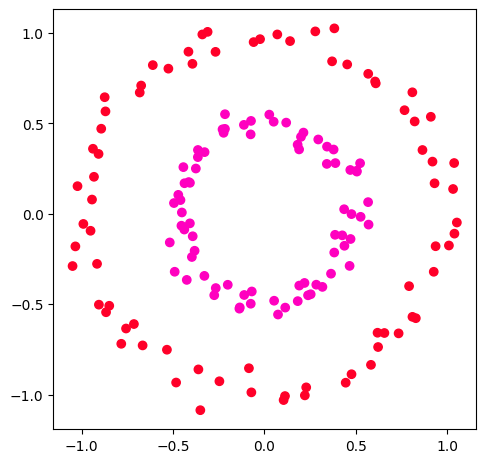

In [49]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)


scatter = ax.scatter(X_blob[:, 1], X_blob[:, 0], c=y_blob, cmap="gist_rainbow", marker="o")

Получилось вот такое интересное распределение

In [50]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.33, random_state=19)

In [51]:
blob_svm = SupportVectorMachine(X_blob_train, y_blob_train, h=0.0005, min_iterations=1000, logging=False)
blob_svm.fit()
print()

In [52]:
blob_qsvm = QuadraSupportVectorMachine(X_blob_train, y_blob_train, h=0.0005, min_iterations=1000)
blob_qsvm.fit()
print()

IndexError: index 3 is out of bounds for axis 0 with size 3

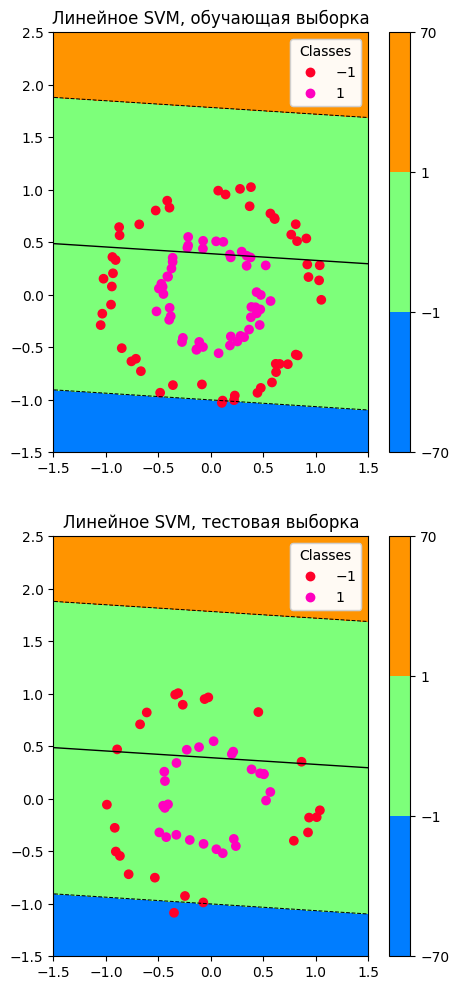

In [53]:

x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = blob_svm.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(223)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.colorbar()
scatter = ax.scatter(X_blob_test[:, 1], X_blob_test[:, 0], c=y_blob_test, cmap="gist_rainbow", marker="o")


plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Линейное SVM, тестовая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax = fig.add_subplot(221)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.colorbar()
scatter = ax.scatter(X_blob_train[:, 1], X_blob_train[:, 0], c=y_blob_train, cmap="gist_rainbow", marker="o")


plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Линейное SVM, обучающая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

w = blob_qsvm.w
z = w[0] + w[1]*xgrid**2 + w[2]*ygrid**2 + w[3]*xgrid + w[4]*ygrid + w[5]*xgrid*ygrid 


ax = fig.add_subplot(222)

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_blob_train[:, 1], X_blob_train[:, 0], c=y_blob_train, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('Квадратичное SVM, обучающая выборка')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")


ax = fig.add_subplot(224)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40], linestyles=["--", '-', '--'])
plt.colorbar()
scatter = ax.scatter(X_blob_test[:, 1], X_blob_test[:, 0], c=y_blob_test, cmap="gist_rainbow", marker="o")


plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Квадратичное SVM, тестовая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


Как мы видим, квадратичное ядро справилось с классификацией на ура, а вот линейное нам тут не поможет. В модели с квадратичным ядром оптимальное разбиение, а также такая # 1 и 2 Задания

# 3 задание дополнительное

# 1 и 2 задания

## Текст заданий


1 Следует привести задачу классификации к бинарной. Т.е. рассматриваем
ирисы 2-х классов: Setosa и non-Setosa.


2 Из признаков оставляем только 2: sepal length и sepal width.

## Небольшие пояснения
Оставляем признаки "sepal_length" и "petal_length", а также выделяем variety в отдельный dataframe. Класс iris-virginica помечаем 1, остальные классы помечаем -1.

In [65]:

y = pd.DataFrame()
X = df[["sepal_length", "sepal_width"]].to_numpy() #отбираем нужные признаки
y['variety'] = df["variety"].apply(lambda x: int(x == "Iris-virginica") - int(x != "Iris-virginica")) #функция для 1 и -1
y = y[['variety']].to_numpy() #переводим в numpy так как наш градиентный спуск работает с нампаем

In [66]:

print("Матрица признаков объектов:")
print(X[:10])
print("\nМатрица-столбец меток классов:")
print(y[45:55])

Матрица признаков объектов:
[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]]

Матрица-столбец меток классов:
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]]


## Выводы по первому и второму заданию
Импортировали данные и убедились в их корректности. Данные нам известные и хорошо знакомые.

# Задание 3


## Текст задания
Выполните процедуру классификации 3 раза. В рамках данной процедуры:

 Разбейте выборку случайным образом на обучающую (100 объектов) и
тестовую.

 Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.

 Приведите формулу разделяющей гиперплоскости.

 Оцените точность классификации на тестовой и обучающей выборках.

## Первая модель(три в одном)
Разбиение выборки на обучающую (мы помним, что объектов 150, потому параметр тестовой части 0.33, чтобы в обучающей было 100)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19) #устанавливаем random_state 19, чтобы не забыть эти данные


Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.
Мы хотим обучить тремя методами градиентного спуска и их сравнить для проведения дальнейших двух запусков

На первом запуске будем сравнивать пакетный, mini-batch и стохастический, на остальных двух будем запускать только один из них

### Пакетный градиентный спуск

In [68]:
svm = SupportVectorMachine(X_train,y_train, h=0.005, min_iterations=1000) #вызывает пакетный градиентный спуск
w_ = svm.fit()  #веса
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
-15.000 + 3.961 x1 + -4.761 x2 = 0


#### Посчитаем метрики

Метрики для тренировочной выборки
accuracy: 0.710
precision: 1.000
recall: 0.121
f1: 0.216

Метрики для тестовой выборки
accuracy: 0.700
precision: 1.000
recall: 0.118
f1: 0.211
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [29  4]]


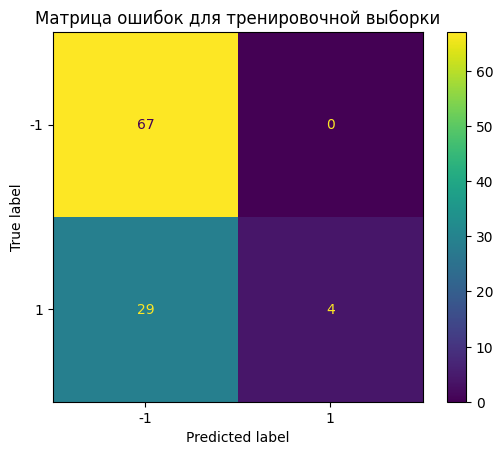

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [15  2]]


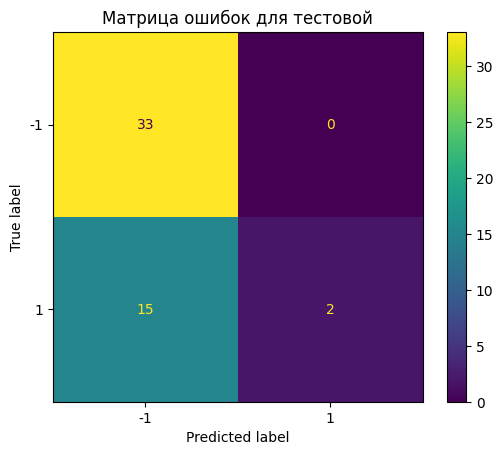

In [69]:
cntr_svm = Counter(X_train, X_test, y_train, y_test, svm)
cntr_svm.try_model()

### mini-batch
Всё то же самое для mini batch, но у него поменяем шаг, чтобы не разошелся

In [70]:
svm_mini_batch = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='mini-batch', batch_size=10) 
w_ = svm_mini_batch.fit()  #веса
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
-1.060 + 0.989 x1 + -1.721 x2 = 0


#### Вновь считаем метрики

Метрики для тренировочной выборки
accuracy: 0.720
precision: 0.556
recall: 0.758
f1: 0.641

Метрики для тестовой выборки
accuracy: 0.700
precision: 0.556
recall: 0.588
f1: 0.571
Матрица ошибок, полученная методом confusion_matrix
 [[47 20]
 [ 8 25]]


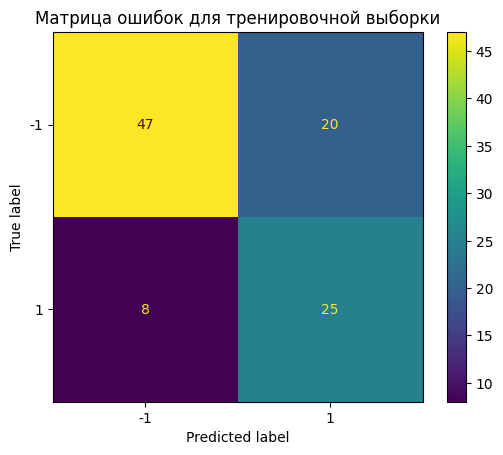

Матрица ошибок, полученная методом confusion_matrix
 [[25  8]
 [ 7 10]]


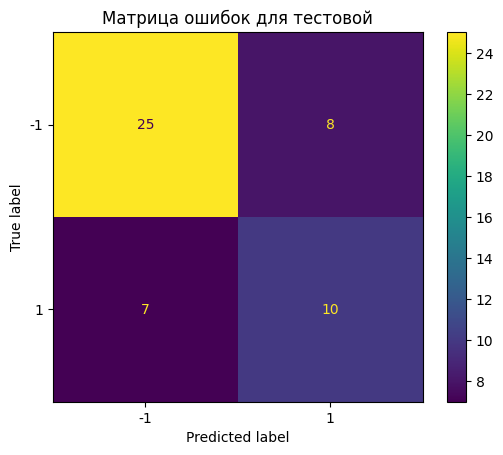

In [71]:
cntr_svm_mini_batch = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cntr_svm_mini_batch.try_model()

### Стохастический градиентный спуск
Остался последний способ, реализованный у нас, это стохастический градиент спуск задаем те же параметры, что и у mini-batch

In [72]:
svm_stochastic = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='stochastic') 
w_ = svm_stochastic.fit()
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
0.475 + 0.118 x1 + -0.660 x2 = 0


#### Метрики для стохастического

Метрики для тренировочной выборки
accuracy: 0.670
precision: 0.000
recall: 0.000
f1: 0.000

Метрики для тестовой выборки
accuracy: 0.660
precision: 0.000
recall: 0.000
f1: 0.000
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [33  0]]


C:\Users\Andrey\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Andrey\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


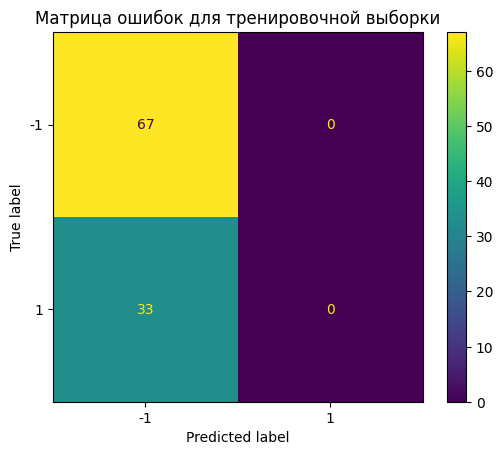

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [17  0]]


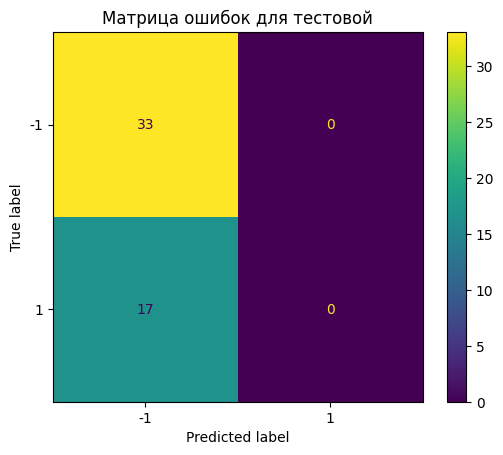

In [73]:
cntr_svm_stochastic = Counter(X_train, X_test, y_train, y_test, svm_stochastic)
cntr_svm_stochastic.try_model()

### Разделяющая гиперплоскость для всех трех

Строим гиперплоскость всех троих способов разделения

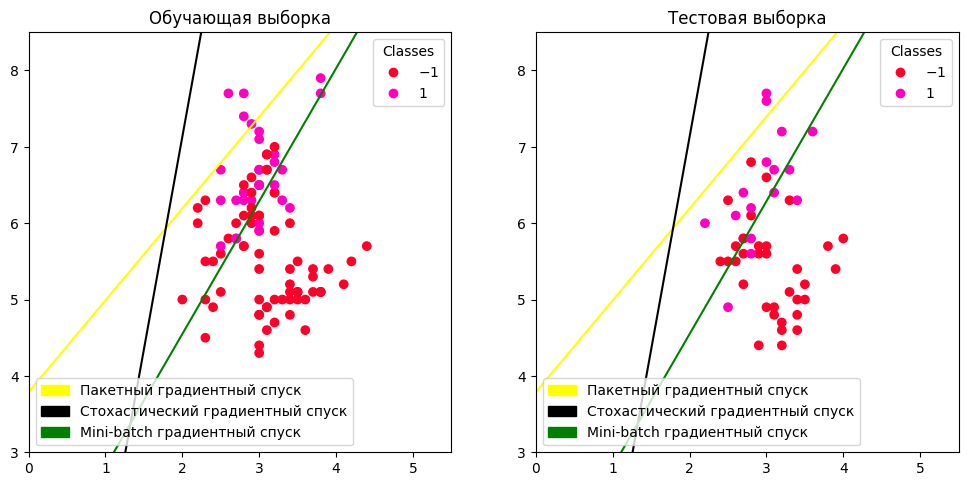

In [75]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

svm_w = svm.w 
svm_stochastic_w = svm_stochastic.w
svm_mini_batch_w = svm_mini_batch.w

svm_z = svm_w[0] + svm_w[2] * xgrid + svm_w[1]*ygrid
svm_stochastic_z = svm_stochastic_w[0] + svm_stochastic_w[2] * xgrid + svm_stochastic_w[1]*ygrid
svm_mini_batch_z = svm_mini_batch_w[0] + svm_mini_batch_w[2] * xgrid + svm_mini_batch_w[1]*ygrid

fig = plt.figure(figsize=(12, 12))

# Обучающая выборка

ax = fig.add_subplot(221)


scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")
plt.contour(x1, x2, svm_z, colors="yellow", levels=[0])
plt.contour(x1, x2, svm_stochastic_z, colors="black", levels=[0])
plt.contour(x1, x2, svm_mini_batch_z, colors="green", levels=[0])

svm_patch = mpatches.Patch(color="yellow", label='Пакетный градиентный спуск')
svm_s_patch = mpatches.Patch(color="black", label='Стохастический градиентный спуск')
svm_m_patch = mpatches.Patch(color="green", label='Mini-batch градиентный спуск')

plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

ax.set_title('Обучающая выборка')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.legend(handles=[svm_patch, svm_s_patch, svm_m_patch])


#тестовая выборка
ax = fig.add_subplot(222)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")

plt.contour(x1, x2, svm_z, colors="yellow", levels=[0])
plt.contour(x1, x2, svm_stochastic_z, colors="black", levels=[0])
plt.contour(x1, x2, svm_mini_batch_z, colors="green", levels=[0])

svm_patch = mpatches.Patch(color="yellow", label='Пакетный градиентный спуск')
svm_s_patch = mpatches.Patch(color="black", label='Стохастический градиентный спуск')
svm_m_patch = mpatches.Patch(color="green", label='Mini-batch градиентный спуск')

plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

ax.set_title('Тестовая выборка')
ax.add_artist(legend1)

ax.legend(handles=[svm_patch, svm_s_patch, svm_m_patch])




### Мини-выводы

По итогу видно, что стохастический оказался худшим, а mini-batch показал лучшие метрики чем пакетный, это странно скорее всего повлиял случайный подсчет градиента, однако теперь для сравнения с остальными будем использовать его, ниже даже можно увидеть что стохастический с меньшей ошибкой оказался хуже пакетного по нашим метрикам

In [76]:
print(f"SVM с пакетной оптимизацией: {svm.q[0]:.02f}")
print(f"SVM с мини-батч оптимизацией: {svm_mini_batch.q[0]:.02f}")
print(f"SVM с стохастической оптимизацией: {svm_stochastic.q[0]:.02f}")

SVM с пакетной оптимизацией: 130.92
SVM с мини-батч оптимизацией: 60.82
SVM с стохастической оптимизацией: 69.47


## Вторая модель(только пакетный)
Новое разбиение для новой модели

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20, )
svm_2 = SupportVectorMachine(X_train,y_train,  h=0.0005, min_iterations=10000, strategy='mini-batch', batch_size=10) 
svm_2.fit()  #веса
w_ = svm_2.fit()

In [80]:
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
-1.584 + 0.928 x1 + -1.266 x2 = 0


Метрики для тренировочной выборки
accuracy: 0.710
precision: 0.550
recall: 0.943
f1: 0.695

Метрики для тестовой выборки
accuracy: 0.720
precision: 0.519
recall: 0.933
f1: 0.667
Матрица ошибок, полученная методом confusion_matrix
 [[38 27]
 [ 2 33]]


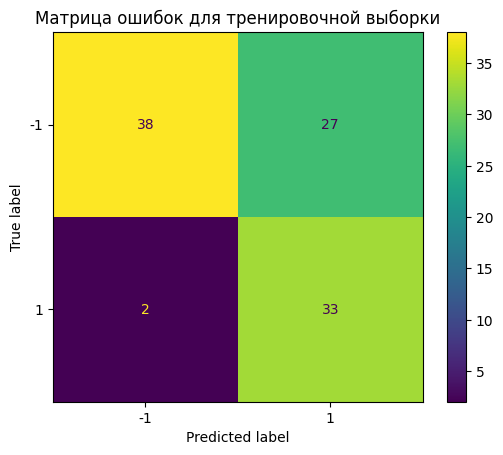

Матрица ошибок, полученная методом confusion_matrix
 [[22 13]
 [ 1 14]]


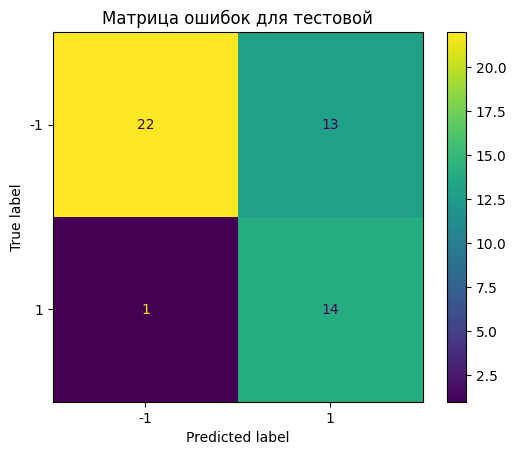

In [81]:
### Метрики
cntr_svm_2 = Counter(X_train, X_test, y_train, y_test, svm_2)
cntr_svm_2.try_model()

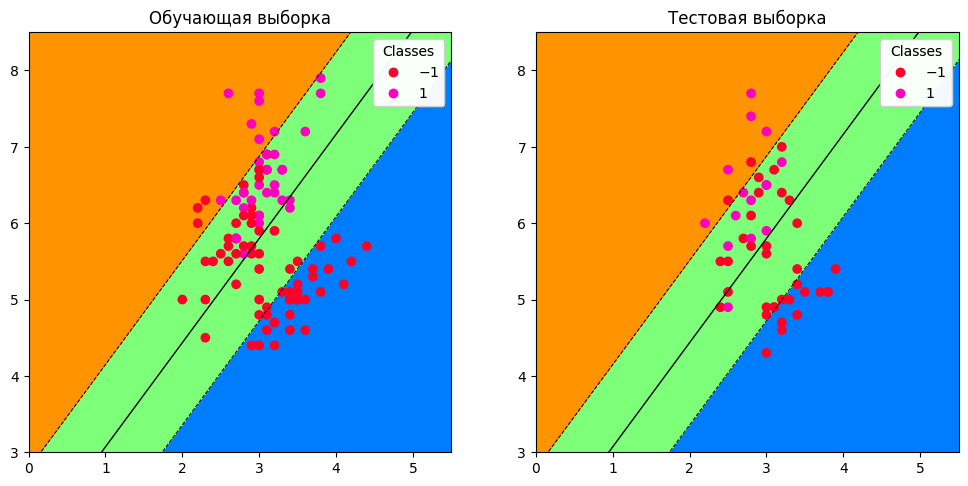

In [82]:
### График гиперплоскости 
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = svm_2.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(221)
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")

ax.set_title('Обучающая выборка')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


#тестовая выборка
ax = fig.add_subplot(222)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")




legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)


plt.show()


По итогу все равно модель не сильно хорошая, рандомит только так из-за того что выборка линейно неразделима

## Третья модель

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=122)
svm_3 = SupportVectorMachine(X_train, y_train, min_iterations=10000, strategy='mini-batch', batch_size=10)
w_ = svm_3.fit()

In [88]:
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
0.464 + 0.027 x1 + -0.519 x2 = 0


Метрики для тренировочной выборки
accuracy: 0.670
precision: 0.000
recall: 0.000
f1: 0.000

Метрики для тестовой выборки
accuracy: 0.660
precision: 0.000
recall: 0.000
f1: 0.000
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [33  0]]


C:\Users\Andrey\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Andrey\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


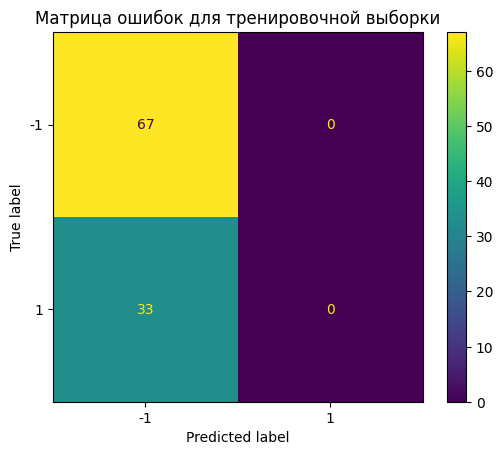

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [17  0]]


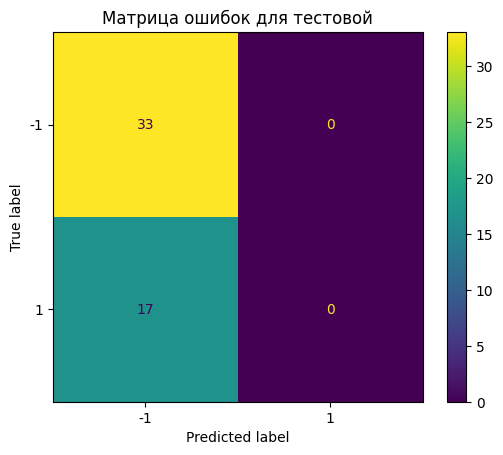

In [89]:
cntr_svm_3 = Counter(X_train, X_test, y_train, y_test, svm_3)
cntr_svm_3.try_model()

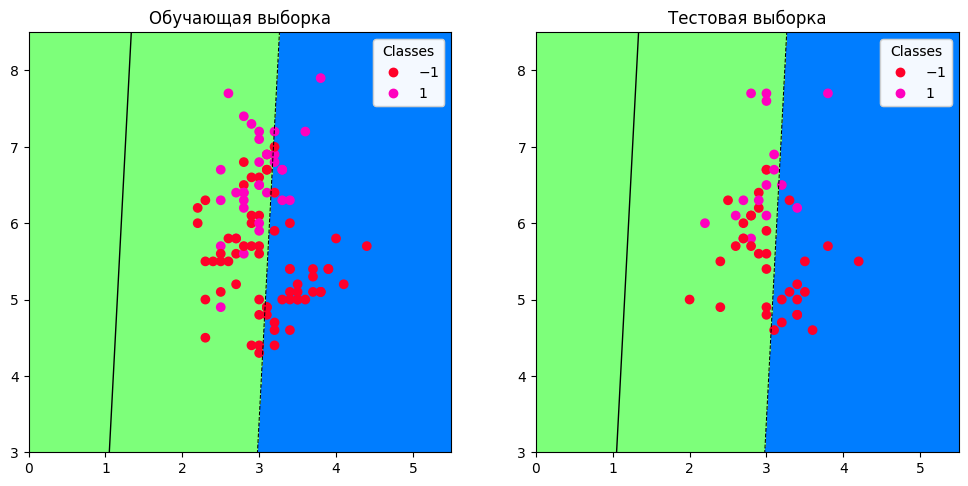

In [91]:

x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = svm_3.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(221)
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")

ax.set_title('Обучающая выборка')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


#тестовая выборка
ax = fig.add_subplot(222)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")




legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)


plt.show()

Из-за линейной неразделимости выборки модель решила, стать константной, что ж это ее выбор мы не в праве ее осуждать за это

# Задание 4

## Текст задания
Сравните итоги выполненных ранее трёх попыток обучения. Сделайте
выводы.

## Пояснения
По итогу везде получилось так, что модель обучалось случайно не имея каких-то конкретных закономерностей связано с тем что выборка линейно неразделима, так что мы теоретически не можем получить хорошие метрики

# Задание 5




## Текст задания
Реализуйте задачу классификации с квадратичной функцией SVM на
последнем наборе обучающей и тестовой выборок (также диаграммой
рассеяния и линией раздела).

Уже реализована, так что воспользуемся ей сразу


        
    
## Решение

Используем последнее разбиение для обучения новой модели

In [92]:
qsvm = QuadraSupportVectorMachine(X_train, y_train, h=0.0005, min_iterations=30000) #инициализация метода
qsvm.init_r() #для перехода в новое пространство
w_ = qsvm.fit()

In [93]:
print("Уравнение разделяющей гиперплоскости:")
print(f"{w_[0]:.03f}" + "".join([f" + {w_[i]:.03f} x{i}" for i in range(1, len(w_))]) + " = 0")

Уравнение разделяющей гиперплоскости:
-3.469 + -9.299 x1 + 0.009 x2 + -5.291 x3 + -14.619 x4 + 10.656 x5 = 0


### Метрики

Метрики для тренировочной выборки
accuracy: 0.820
precision: 0.683
recall: 0.848
f1: 0.757

Метрики для тестовой выборки
accuracy: 0.800
precision: 0.667
recall: 0.824
f1: 0.737
Матрица ошибок, полученная методом confusion_matrix
 [[54 13]
 [ 5 28]]


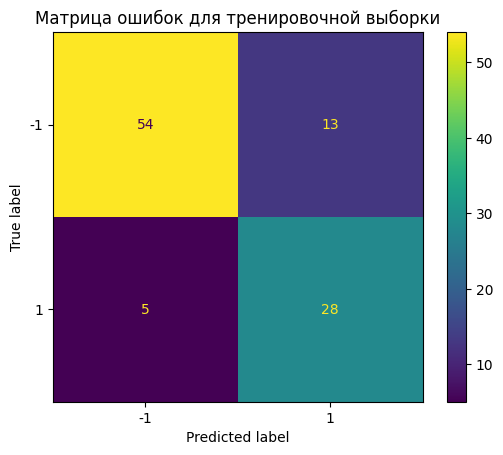

Матрица ошибок, полученная методом confusion_matrix
 [[26  7]
 [ 3 14]]


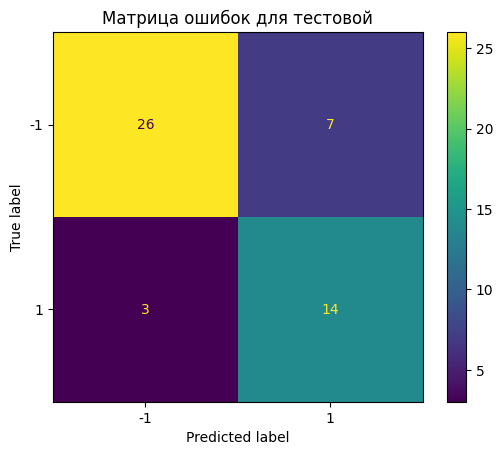

In [94]:
cntr_qsvm = Counter(X_train, X_test, y_train, y_test, qsvm)
cntr_qsvm.try_model()

### Линии уровня гиперплоскости

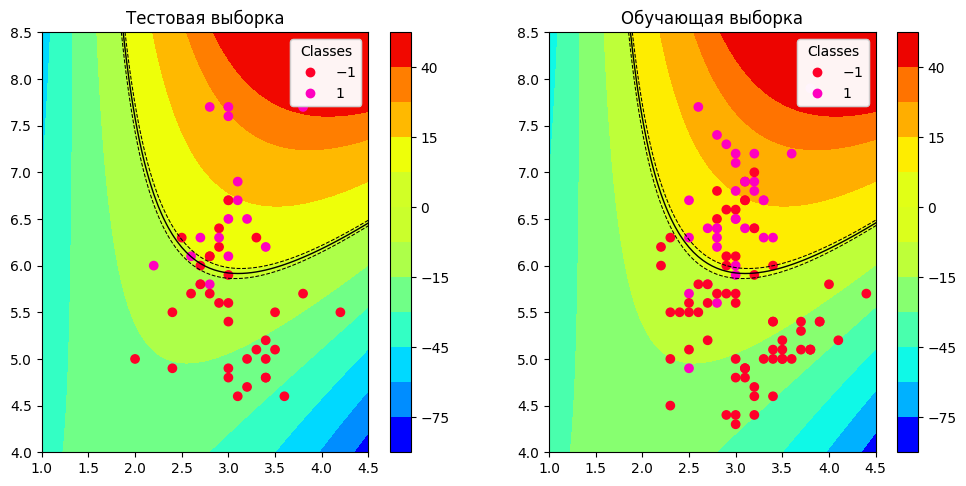

In [106]:
x1 = np.arange(-15, 20, 0.05)
x2 = np.arange(-15, 20, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

w = qsvm.w  
z = w[0] + w[1]*xgrid**2 + w[2]*ygrid**2 + w[3]*xgrid + w[4]*ygrid + w[5]*xgrid*ygrid 

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

plt.contourf(x1, x2, z, cmap="jet", levels=[-120, -75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40, 80])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('Тестовая выборка')
plt.xlim(1, 4.5)
plt.ylim(4, 8.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

ax = fig.add_subplot(222)


plt.contourf(x1, x2, z, cmap="jet", levels=[-130, -75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40, 80])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")
plt.xlim(1, 4.5)
plt.ylim(4, 8.5)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Обучающая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


plt.show()

## Выводы по svm с квадратичным ядром

Намного лучше справляется с задачей обобщения, и даже метрики неплохие, можно сделать вывод, что модель не так уж плоха и с помощью нее уже можно выполнить седьмое задание


# Задание 6


## Текст задания
Сравните точность классификации на тестовой выборке с линейной SVM.
Объясните результат.


## Решение
Точность классификации отличается, казалось бы, несильно, однако точность 1 и любая меньше 1 - абсолютно разные результаты. 

В обобщающей способности линейного классификатора нет сомнений поскольку это самая простая модель, за исключением константной, которая только может быть. 

Однако квадратичная могла и сильно подстроиться под ту одну точку, хотя в реальных данных там может оказаться много точек другого класса.

Может оказаться так, что все-таки там природно розовые точки, потому можно сделать вывод, что обе модели хорошо справились со своей задачей

# Задание 7
## Текст задания
Определите сорт 20 объектов из дополнительной выборки (файл «Dop.csv»).
Качество определения сорта проверит преподаватель.

In [107]:
y_dop = pd.DataFrame()
X_dop = df_dop[["Sepal.L", "Petal.L"]].to_numpy()  #отбираем нужные признаки

y_pred_qsvm_dop = qsvm.predict(X_dop)
y_pred_svm_dop = svm_3.predict(X_dop)

In [108]:
y_pred_qsvm_dop = qsvm.predict(X_dop)
y_pred_svm_dop = svm_3.predict(X_dop)

## Ответы

In [109]:
ans = pd.DataFrame()
ans["SVM Квадратичное ядро"] = y_pred_qsvm_dop[:, 0]  #Ответы по модели с квадратичным ядром
ans["SVM линейное ядро"] = y_pred_svm_dop[:, 0]  # Ответы по линейной модели
ans["Совпадение ответов"] = ans["SVM Квадратичное ядро"] == ans["SVM линейное ядро"]

ans

,SVM Квадратичное ядро,SVM линейное ядро,Совпадение ответов
0,-1.0,-1.0,True
1,-1.0,-1.0,True
2,-1.0,-1.0,True
3,-1.0,-1.0,True
4,-1.0,-1.0,True
5,-1.0,-1.0,True
6,-1.0,-1.0,True
7,-1.0,-1.0,True
8,-1.0,-1.0,True
9,-1.0,-1.0,True


### Пояснение к ответам

Неожиданные результаты более-менее интепретируемая модель и константная сошлись в едином мнении

(500, 500)


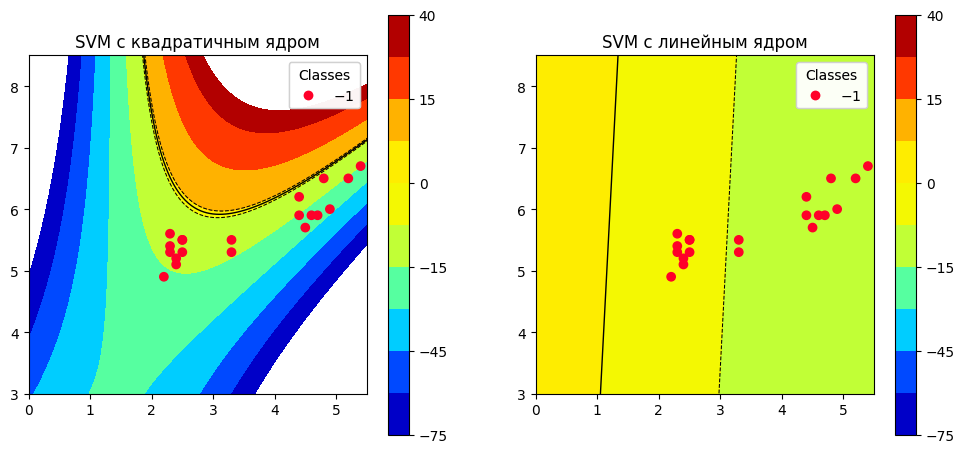

In [112]:

##  Визуализация ответов
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

xgrid, ygrid = np.meshgrid(x1, x2)

w = qsvm.w
z = w[0] + w[1] * xgrid ** 2 + w[2] * ygrid ** 2 + w[3] * xgrid + w[4] * ygrid + w[5] * xgrid * ygrid

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_dop[:, 1], X_dop[:, 0], c=y_pred_qsvm_dop, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('SVM с квадратичным ядром')
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

ax = fig.add_subplot(222)
w = svm_3.w
z = w[0] + w[2] * xgrid + w[1] * ygrid

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_dop[:, 1], X_dop[:, 0], c=y_pred_svm_dop, cmap="gist_rainbow", marker="o")
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
ax.set_aspect('equal', adjustable='box')
ax.set_title('SVM с линейным ядром')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
print(z.shape)

plt.show()

Модели сошлись к единому мнению, константная и квадратичная. Cреди них нет virginiсa.  По факту у квадратичной модели есть четкое обоснование и интерпретация, в то время как у линейной своя философия

# Финальный вывод для 3 задания

Понятно почему так произошло, из-за линейной неразделимости выборки. Используя квадратичное ядро нам удалось избежать проблем связанных с этим, конечно из-за наложения классов друг на друга невозможно описать линию разделения между ними

# Самый финальный вывод

Нам удалось изучить SVM и его ядра, а так же посмотреть его поведение в различных ситуациях. Понять математику ядер и функции потерь. Адаптировать SVM для градиентного спуска. 

# Конец